# Réseau de neurones dense

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

from joblib import dump, load # pour enregistrer et charger les modèles.
#from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

from tensorflow.keras.layers import Input, Dense #Pour instancier une couche Dense et une d'Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision

n_coeurs = 4

In [2]:
#### Callbacks:

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.0001,  # arrête si le changement est inférieur est min_delta
                               patience = 5,
                               mode = 'min', # In min mode, training will stop when the quantity monitored has stopped decreasing
                               restore_best_weights = True,
                               verbose = 1)

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              min_delta = 0.0001,
                              patience = 3,
                              factor = 0.1,
                              mode = 'min',
                              cooldown = 4,
                              verbose = 1)

In [3]:
# Instanciation df
df = pd.read_csv('../../../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

###### Proportions initiales target:
#RainTomorrow
#0    0.778382
#1    0.221618

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE: pour pouvoir spécifier n_jobs, il faut désormais le faire en instanciant en amont un nearest neighbors compatible, ici NearestNeighbors
nn_smote = NearestNeighbors(n_neighbors = 5, n_jobs = n_coeurs)
smote = SMOTE(random_state = 12, k_neighbors = nn_smote)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

Classes échantillon SMOTE : {0: 82189, 1: 82189}


In [4]:
X_sm.shape

(164378, 28)

In [5]:
inputs = Input(shape = (28), name = 'Input') # il y a 28 variables explicatives

dense1 = Dense(units = 10, activation = 'tanh', name = 'Dense_1') # https://www.tensorflow.org/api_docs/python/tf/keras/activations
dense2 = Dense(units = 10, activation = 'tanh', name = 'Dense_2')
dense3 = Dense(units = 6, activation = 'tanh', name = 'Dense_3')
dense4 = Dense(units = 2, activation = 'tanh', name = 'Dense_4')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model = Model(inputs = inputs, outputs = outputs)


model.compile(loss = 'binary_crossentropy',      # https://www.tensorflow.org/api_docs/python/tf/keras/losses
              optimizer = 'adam',               # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
              metrics = ['accuracy'])          # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28)]              0         
                                                                 
 Dense_1 (Dense)             (None, 10)                290       
                                                                 
 Dense_2 (Dense)             (None, 10)                110       
                                                                 
 Dense_3 (Dense)             (None, 6)                 66        
                                                                 
 Dense_4 (Dense)             (None, 2)                 14        
                                                                 
Total params: 480
Trainable params: 480
Non-trainable params: 0
_________________________________________________________________


In [9]:
model_history = model.fit(X_sm, y_sm, epochs = 50, batch_size = 128, validation_split = 0.2)# , callbacks = [early_stopping, reduce_lr])

Epoch 1/50
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5466 - accuracy: 0.5586 - val_loss: 0.6428 - val_accuracy: 0.3596
Epoch 2/50
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5417 - accuracy: 0.5697 - val_loss: 0.6592 - val_accuracy: 0.3595
Epoch 3/50
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5365 - accuracy: 0.5678 - val_loss: 0.6585 - val_accuracy: 0.3587
Epoch 4/50
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5302 - accuracy: 0.5501 - val_loss: 0.6780 - val_accuracy: 0.3712
Epoch 5/50
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5268 - accuracy: 0.5394 - val_loss: 0.6958 - val_accuracy: 0.3813
Epoch 6/50
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5220 - accuracy: 0.5028 - val_loss: 0.6611 - val_accuracy: 0.3689
Epoch 7/50
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5174 - accuracy: 0.4808 - val_loss: 0.6855 - val_accuracy:

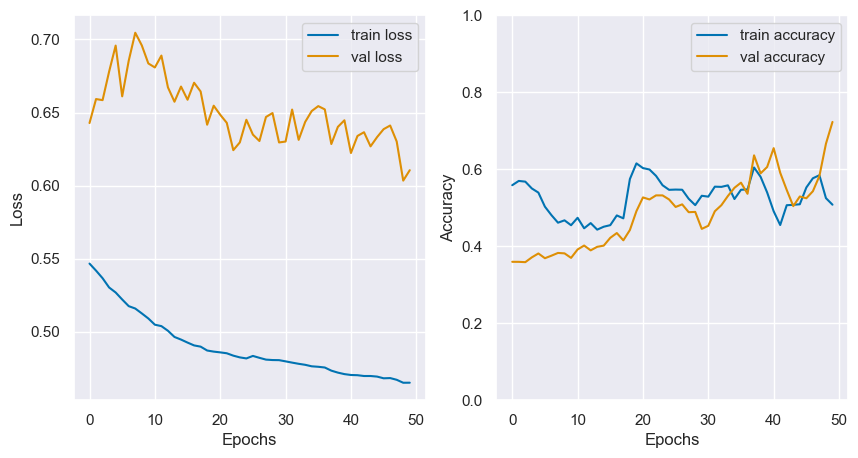

In [10]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(model_history.history['loss'], label = 'train loss')
plt.plot(model_history.history['val_loss'], label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.legend()

plt.subplot(122)
plt.plot(model_history.history['accuracy'], label = 'train accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()

plt.show()

In [11]:
test_pred = model.predict(X_test)

y_test_class = y_test
y_pred_class = np.argmax(test_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

1100/1100 [==============================] - 1s 688us/step
              precision    recall  f1-score   support

           0       0.82      0.35      0.49     27397
           1       0.24      0.72      0.36      7800

    accuracy                           0.43     35197
   macro avg       0.53      0.54      0.43     35197
weighted avg       0.69      0.43      0.46     35197

[[ 9669 17728]
 [ 2185  5615]]


C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\AlexW\anaconda3\envs\TestDL\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if